In [1]:
!pip install -U transformers peft accelerate bitsandbytes


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.0/557.0 kB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 18.5 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.3
    Uninstalling transformers-4.57.3:
      Successfully uninstalled transformers-4.57.3
  Attempting uninstall: peft
    Found existing installation: peft 0.18.0
    Uninstalling peft-0.18.0:
      Successfully uninstalled peft-0.18.0


In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

MODEL_NAME = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
)

model.eval()
print("TinyLlama loaded in 4-bit successfully")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

TinyLlama loaded in 4-bit successfully


In [3]:
from peft import prepare_model_for_kbit_training

model = prepare_model_for_kbit_training(model)
print("Model prepared for k-bit training")


Model prepared for k-bit training


In [4]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 4,505,600 || all params: 1,104,553,984 || trainable%: 0.4079


In [5]:
model.gradient_checkpointing_enable()
print("Gradient checkpointing enabled")


Gradient checkpointing enabled


In [7]:
# Recreate a tiny training set (5 samples)

def medmcqa_to_instruction(example):
    options = {
        "A": example["opa"],
        "B": example["opb"],
        "C": example["opc"],
        "D": example["opd"],
    }
    correct_option = ["A", "B", "C", "D"][example["cop"]]
    answer = options[correct_option]

    prompt = (
        "You are a medical assistant.\n\n"
        f"Question:\n{example['question']}\n\n"
        "Answer briefly and precisely."
    )

    return {
        "text": prompt + "\n" + answer
    }

# Load dataset again (runtime was restarted)
from datasets import load_dataset
dataset = load_dataset("medmcqa", split="train[:10]")

train_samples = [medmcqa_to_instruction(dataset[i]) for i in range(5)]

train_samples



README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/85.9M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/936k [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/1.48M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/182822 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6150 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4183 [00:00<?, ? examples/s]

[{'text': 'You are a medical assistant.\n\nQuestion:\nChronic urethral obstruction due to benign prismatic hyperplasia can lead to the following change in kidney parenchyma\n\nAnswer briefly and precisely.\nAtrophy'},
 {'text': 'You are a medical assistant.\n\nQuestion:\nWhich vitamin is supplied from only animal source:\n\nAnswer briefly and precisely.\nVitamin B12'},
 {'text': 'You are a medical assistant.\n\nQuestion:\nAll of the following are surgical options for morbid obesity except -\n\nAnswer briefly and precisely.\nRoux en Y Duodenal By pass'},
 {'text': 'You are a medical assistant.\n\nQuestion:\nFollowing endaerectomy on the right common carotid, a patient is found to be blind in the right eye. It is appears that a small thrombus embolized during surgery and lodged in the aery supplying the optic nerve. Which aery would be blocked?\n\nAnswer briefly and precisely.\nCentral aery of the retina'},
 {'text': 'You are a medical assistant.\n\nQuestion:\nGrowth hormone has its effe

In [8]:
tokenized = tokenize_fn(
    [s["text"] for s in train_samples],
    max_length=128,
)

tokenized = {k: v.to(model.device) for k, v in tokenized.items()}


In [9]:
tokenized.keys(), tokenized["input_ids"].shape


(dict_keys(['input_ids', 'attention_mask']), torch.Size([5, 128]))

In [10]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-4)
pad_token_id = tokenizer.pad_token_id


In [11]:
model.train()

losses = []

for step in range(10):
    idx = step % len(train_samples)

    input_ids = tokenized["input_ids"][idx:idx+1]
    attention_mask = tokenized["attention_mask"][idx:idx+1]

    labels = input_ids.clone()
    labels[labels == pad_token_id] = -100

    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        labels=labels,
    )

    loss = outputs.loss
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    losses.append(loss.item())
    print(f"Step {step+1} | Loss: {loss.item():.4f}")


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step 1 | Loss: 3.7210
Step 2 | Loss: 3.6350
Step 3 | Loss: 3.9732
Step 4 | Loss: 3.2467
Step 5 | Loss: 3.9181
Step 6 | Loss: 3.0963
Step 7 | Loss: 2.9159
Step 8 | Loss: 3.2052
Step 9 | Loss: 2.8658
Step 10 | Loss: 3.0357


In [12]:
def get_lora_norms(model):
    norms = {}
    for name, param in model.named_parameters():
        if "lora" in name.lower() and param.requires_grad:
            norms[name] = param.detach().float().norm().item()
    return norms

lora_norms = get_lora_norms(model)

# Show a few
for k in list(lora_norms.keys())[:5]:
    print(k, "→", round(lora_norms[k], 6))

print("Total LoRA params:", len(lora_norms))


base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight → 2.312279
base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight → 0.182824
base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight → 2.309466
base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight → 0.071036
base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight → 2.311265
Total LoRA params: 176


In [13]:
import json
from pathlib import Path

LOG_PATH = Path("training_log.jsonl")

def log_step(step, loss, lora_norms):
    record = {
        "step": step,
        "loss": loss,
        "lora_norms": lora_norms,
    }
    with open(LOG_PATH, "a") as f:
        f.write(json.dumps(record) + "\n")


In [15]:
def simplify_lora_names(lora_norms):
    simplified = {}
    for name, value in lora_norms.items():
        if "layers." in name:
            layer = name.split("layers.")[1].split(".")[0]
            proj = name.split("self_attn.")[1].split(".")[0]
            key = f"layer_{layer}.{proj}"
            simplified[key] = value
    return simplified



In [16]:
model.train()

for step in range(1, 21):  # 20 steps now
    idx = (step - 1) % len(train_samples)

    input_ids = tokenized["input_ids"][idx:idx+1]
    attention_mask = tokenized["attention_mask"][idx:idx+1]

    labels = input_ids.clone()
    labels[labels == pad_token_id] = -100

    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        labels=labels,
    )

    loss = outputs.loss
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    # collect LoRA norms
    raw_norms = get_lora_norms(model)
    clean_norms = simplify_lora_names(raw_norms)

    log_step(
        step=step,
        loss=loss.item(),
        lora_norms=clean_norms,
    )

    print(f"Step {step} | Loss: {loss.item():.4f} | Logged")


Step 1 | Loss: 2.3911 | Logged
Step 2 | Loss: 2.0232 | Logged
Step 3 | Loss: 2.2808 | Logged
Step 4 | Loss: 2.4369 | Logged
Step 5 | Loss: 2.0770 | Logged
Step 6 | Loss: 1.7601 | Logged
Step 7 | Loss: 1.5375 | Logged
Step 8 | Loss: 1.8267 | Logged
Step 9 | Loss: 2.2164 | Logged
Step 10 | Loss: 1.6008 | Logged
Step 11 | Loss: 1.4190 | Logged
Step 12 | Loss: 1.3342 | Logged
Step 13 | Loss: 1.4482 | Logged
Step 14 | Loss: 1.9993 | Logged
Step 15 | Loss: 1.2200 | Logged
Step 16 | Loss: 1.1781 | Logged
Step 17 | Loss: 1.0262 | Logged
Step 18 | Loss: 1.1496 | Logged
Step 19 | Loss: 1.7754 | Logged
Step 20 | Loss: 0.8396 | Logged


In [17]:
# Show first 3 log entries
with open(LOG_PATH) as f:
    for _ in range(3):
        print(f.readline())


{"step": 1, "loss": 2.3910984992980957, "lora_norms": {"layer_0.q_proj": 0.19591958820819855, "layer_0.k_proj": 0.0763276219367981, "layer_0.v_proj": 0.07036139816045761, "layer_0.o_proj": 0.20901405811309814, "layer_1.q_proj": 0.21092469990253448, "layer_1.k_proj": 0.07242608815431595, "layer_1.v_proj": 0.07132229208946228, "layer_1.o_proj": 0.20746828615665436, "layer_2.q_proj": 0.21113820374011993, "layer_2.k_proj": 0.08200397342443466, "layer_2.v_proj": 0.068575918674469, "layer_2.o_proj": 0.2113669514656067, "layer_3.q_proj": 0.19658014178276062, "layer_3.k_proj": 0.07036589831113815, "layer_3.v_proj": 0.07362031191587448, "layer_3.o_proj": 0.20843781530857086, "layer_4.q_proj": 0.20064777135849, "layer_4.k_proj": 0.06859800964593887, "layer_4.v_proj": 0.07352249324321747, "layer_4.o_proj": 0.2061709463596344, "layer_5.q_proj": 0.20295102894306183, "layer_5.k_proj": 0.0680137649178505, "layer_5.v_proj": 0.0703144371509552, "layer_5.o_proj": 0.20827583968639374, "layer_6.q_proj": 0

In [19]:
import json

records = []
with open("training_log.jsonl") as f:
    for line in f:
        records.append(json.loads(line))

len(records), records[0].keys()


(20, dict_keys(['step', 'loss', 'lora_norms']))

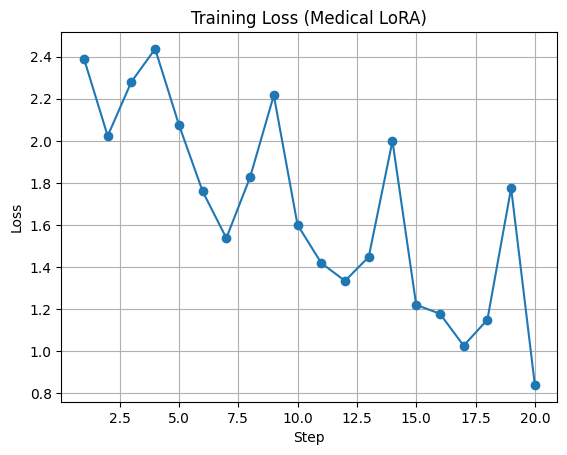

In [20]:
import matplotlib.pyplot as plt

steps = [r["step"] for r in records]
losses = [r["loss"] for r in records]

plt.plot(steps, losses, marker="o")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss (Medical LoRA)")
plt.grid(True)
plt.show()


In [21]:
import pandas as pd

# Build dataframe: rows = steps, columns = layer.proj
rows = []
for r in records:
    row = {"step": r["step"]}
    row.update(r["lora_norms"])
    rows.append(row)

df = pd.DataFrame(rows).set_index("step")
df.head()


,layer_0.q_proj,layer_0.k_proj,layer_0.v_proj,layer_0.o_proj,layer_1.q_proj,layer_1.k_proj,layer_1.v_proj,layer_1.o_proj,layer_2.q_proj,layer_2.k_proj,...,layer_19.v_proj,layer_19.o_proj,layer_20.q_proj,layer_20.k_proj,layer_20.v_proj,layer_20.o_proj,layer_21.q_proj,layer_21.k_proj,layer_21.v_proj,layer_21.o_proj
step,,,,,,,,,,,,,,,,,,,,,
1,0.195920,0.076328,0.070361,0.209014,0.210925,0.072426,0.071322,0.207468,0.211138,0.082004,...,0.079984,0.239460,0.226638,0.079588,0.083742,0.251380,0.219897,0.082055,0.087797,0.248833
2,0.208457,0.081612,0.074591,0.221547,0.223400,0.076888,0.075662,0.221135,0.224310,0.087516,...,0.086683,0.260075,0.244347,0.085867,0.090724,0.273058,0.238169,0.089166,0.095716,0.270899
3,0.221610,0.086829,0.078667,0.233325,0.235631,0.081267,0.079819,0.233861,0.236577,0.092516,...,0.093163,0.280227,0.261514,0.091954,0.097541,0.293794,0.256261,0.096281,0.103451,0.292478
4,0.234343,0.091743,0.082675,0.244884,0.247511,0.085535,0.083873,0.246232,0.247934,0.096788,...,0.099353,0.299275,0.277902,0.097629,0.104009,0.313203,0.273496,0.103041,0.110641,0.312658
5,0.247477,0.096877,0.086582,0.255913,0.258233,0.089441,0.087654,0.257549,0.257496,0.099769,...,0.105238,0.317058,0.293600,0.103106,0.109975,0.330873,0.289804,0.109418,0.117158,0.331088


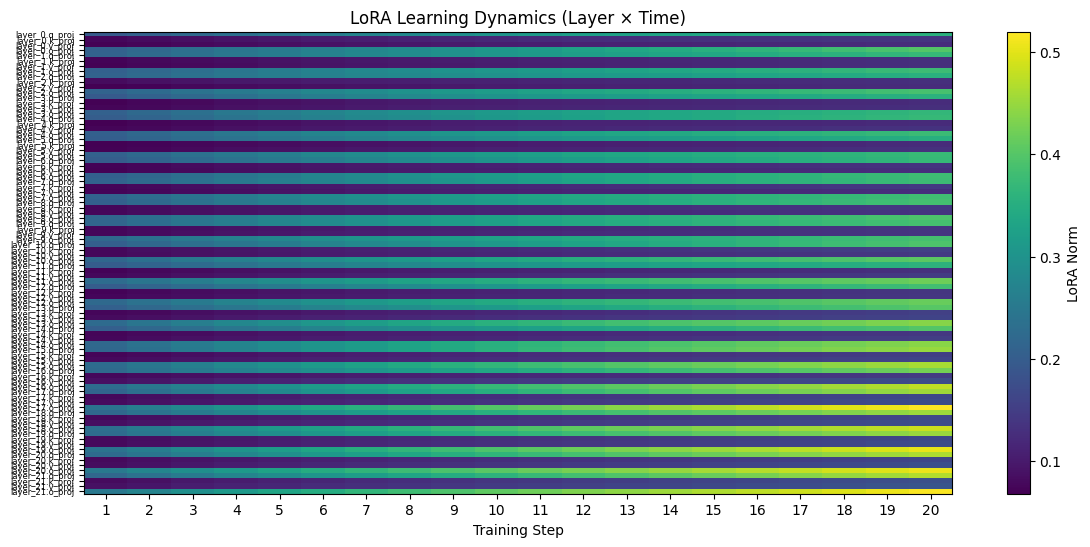

In [22]:
plt.figure(figsize=(14, 6))
plt.imshow(df.T, aspect="auto", interpolation="nearest")
plt.colorbar(label="LoRA Norm")
plt.yticks(range(len(df.columns)), df.columns, fontsize=6)
plt.xticks(range(len(df.index)), df.index)
plt.xlabel("Training Step")
plt.title("LoRA Learning Dynamics (Layer × Time)")
plt.show()


In [23]:
# Total LoRA norm per step (sum over all layers)
df["total_lora_norm"] = df.sum(axis=1)

df[["total_lora_norm"]].head()


,total_lora_norm
step,
1,12.863829
2,13.796283
3,14.699908
4,15.568173
5,16.384845


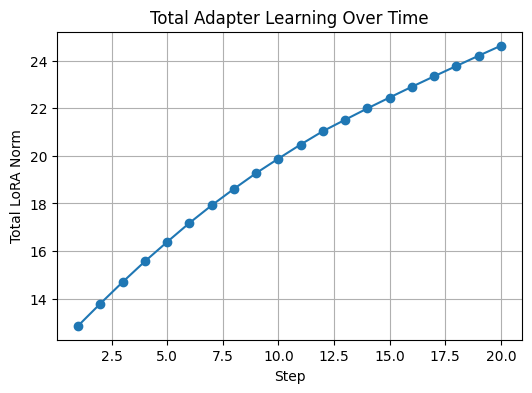

In [24]:
plt.figure(figsize=(6, 4))
plt.plot(df.index, df["total_lora_norm"], marker="o")
plt.xlabel("Step")
plt.ylabel("Total LoRA Norm")
plt.title("Total Adapter Learning Over Time")
plt.grid(True)
plt.show()


In [25]:
import numpy as np

def early_slope(series, n_steps=5):
    x = np.arange(n_steps)
    y = series.iloc[:n_steps].values
    return np.polyfit(x, y, 1)[0]

early_learning_slope = early_slope(df["total_lora_norm"], n_steps=5)
early_learning_slope


np.float64(0.8813922040164475)

In [26]:
THRESH = 0.01  # small but non-zero

final_norms = df.iloc[-1]
active_layers = (final_norms > THRESH).sum()
total_layers = len(final_norms)

active_layers, total_layers


(np.int64(89), 89)

In [27]:
activation_ratio = active_layers / total_layers
activation_ratio


np.float64(1.0)

In [28]:
def classify_run(df):
    slope = early_slope(df["total_lora_norm"], n_steps=5)
    activation_ratio = ((df.iloc[-1] > 0.01).sum()) / len(df.columns)

    if slope < 0.001:
        return "dead"
    elif activation_ratio < 0.3:
        return "degraded"
    else:
        return "healthy"

classify_run(df)


'healthy'

In [29]:
optimizer = AdamW(model.parameters(), lr=1e-6)  # was 2e-4


In [34]:
LOG_PATH = Path("training_log_dead.jsonl")


In [36]:
from pathlib import Path
import json

LOG_PATH_DEAD = Path("training_log_dead.jsonl")

# clear file if it somehow exists
if LOG_PATH_DEAD.exists():
    LOG_PATH_DEAD.unlink()

def log_dead_step(step, loss, lora_norms):
    record = {
        "step": step,
        "loss": loss,
        "lora_norms": lora_norms,
    }
    with open(LOG_PATH_DEAD, "a") as f:
        f.write(json.dumps(record) + "\n")



In [37]:
from torch.optim import AdamW

optimizer_dead = AdamW(model.parameters(), lr=1e-6)  # VERY LOW LR
pad_token_id = tokenizer.pad_token_id


In [38]:
model.train()

for step in range(1, 21):
    idx = (step - 1) % len(train_samples)

    input_ids = tokenized["input_ids"][idx:idx+1]
    attention_mask = tokenized["attention_mask"][idx:idx+1]

    labels = input_ids.clone()
    labels[labels == pad_token_id] = -100

    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        labels=labels,
    )

    loss = outputs.loss
    loss.backward()

    optimizer_dead.step()
    optimizer_dead.zero_grad()

    raw_norms = get_lora_norms(model)
    clean_norms = simplify_lora_names(raw_norms)

    log_dead_step(
        step=step,
        loss=loss.item(),
        lora_norms=clean_norms,
    )

    print(f"[DEAD] Step {step} | Loss: {loss.item():.4f}")


[DEAD] Step 1 | Loss: 0.8404
[DEAD] Step 2 | Loss: 0.7795
[DEAD] Step 3 | Loss: 0.9152
[DEAD] Step 4 | Loss: 1.6444
[DEAD] Step 5 | Loss: 0.7214
[DEAD] Step 6 | Loss: 0.8350
[DEAD] Step 7 | Loss: 0.7760
[DEAD] Step 8 | Loss: 0.9064
[DEAD] Step 9 | Loss: 1.6442
[DEAD] Step 10 | Loss: 0.7168
[DEAD] Step 11 | Loss: 0.8344
[DEAD] Step 12 | Loss: 0.7724
[DEAD] Step 13 | Loss: 0.9038
[DEAD] Step 14 | Loss: 1.6385
[DEAD] Step 15 | Loss: 0.7182
[DEAD] Step 16 | Loss: 0.8293
[DEAD] Step 17 | Loss: 0.7708
[DEAD] Step 18 | Loss: 0.8990
[DEAD] Step 19 | Loss: 1.6364
[DEAD] Step 20 | Loss: 0.7111


In [39]:
dead_records = []
with open("training_log_dead.jsonl") as f:
    for line in f:
        dead_records.append(json.loads(line))

len(dead_records)


20

In [40]:
import pandas as pd

rows_dead = []
for r in dead_records:
    row = {"step": r["step"]}
    row.update(r["lora_norms"])
    rows_dead.append(row)

df_dead = pd.DataFrame(rows_dead).set_index("step")
df_dead["total_lora_norm"] = df_dead.sum(axis=1)
df_dead.head()


,layer_0.q_proj,layer_0.k_proj,layer_0.v_proj,layer_0.o_proj,layer_1.q_proj,layer_1.k_proj,layer_1.v_proj,layer_1.o_proj,layer_2.q_proj,layer_2.k_proj,...,layer_19.o_proj,layer_20.q_proj,layer_20.k_proj,layer_20.v_proj,layer_20.o_proj,layer_21.q_proj,layer_21.k_proj,layer_21.v_proj,layer_21.o_proj,total_lora_norm
step,,,,,,,,,,,,,,,,,,,,,
1,0.357195,0.137909,0.126894,0.399893,0.370351,0.128182,0.129381,0.378188,0.355137,0.129201,...,0.504084,0.465089,0.161671,0.176072,0.507178,0.466996,0.179095,0.187323,0.516472,24.630393
2,0.357198,0.137911,0.126901,0.399932,0.370339,0.128180,0.129388,0.378201,0.355122,0.129183,...,0.504109,0.465111,0.161682,0.176083,0.507208,0.467021,0.179108,0.187341,0.516504,24.631371
3,0.357202,0.137912,0.126909,0.399970,0.370338,0.128181,0.129394,0.378213,0.355108,0.129169,...,0.504137,0.465138,0.161697,0.176096,0.507235,0.467045,0.179117,0.187358,0.516538,24.632420
4,0.357212,0.137911,0.126918,0.400006,0.370340,0.128184,0.129401,0.378225,0.355098,0.129157,...,0.504163,0.465167,0.161710,0.176109,0.507264,0.467072,0.179128,0.187374,0.516571,24.633589
5,0.357217,0.137913,0.126927,0.400041,0.370341,0.128186,0.129408,0.378236,0.355093,0.129147,...,0.504191,0.465193,0.161724,0.176122,0.507291,0.467100,0.179142,0.187390,0.516604,24.634725


In [41]:
classify_run(df_dead)


'healthy'

In [42]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

MODEL_NAME = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
)

model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, lora_config)
model.gradient_checkpointing_enable()
model.train()

print("Fresh model + fresh LoRA loaded")


Fresh model + fresh LoRA loaded


In [43]:
from torch.optim import AdamW

optimizer_dead = AdamW(model.parameters(), lr=1e-6)
pad_token_id = tokenizer.pad_token_id


In [44]:
from pathlib import Path
import json

LOG_PATH_DEAD = Path("training_log_dead.jsonl")
if LOG_PATH_DEAD.exists():
    LOG_PATH_DEAD.unlink()

def log_dead_step(step, loss, lora_norms):
    with open(LOG_PATH_DEAD, "a") as f:
        f.write(json.dumps({
            "step": step,
            "loss": loss,
            "lora_norms": lora_norms
        }) + "\n")


In [45]:
for step in range(1, 21):
    idx = (step - 1) % len(train_samples)

    input_ids = tokenized["input_ids"][idx:idx+1]
    attention_mask = tokenized["attention_mask"][idx:idx+1]

    labels = input_ids.clone()
    labels[labels == pad_token_id] = -100

    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        labels=labels,
    )

    loss = outputs.loss
    loss.backward()

    optimizer_dead.step()
    optimizer_dead.zero_grad()

    raw_norms = get_lora_norms(model)
    clean_norms = simplify_lora_names(raw_norms)

    log_dead_step(step, loss.item(), clean_norms)

    print(f"[DEAD] Step {step} | Loss: {loss.item():.4f}")


[DEAD] Step 1 | Loss: 3.7210
[DEAD] Step 2 | Loss: 3.7297
[DEAD] Step 3 | Loss: 4.1731
[DEAD] Step 4 | Loss: 3.3705
[DEAD] Step 5 | Loss: 4.2977
[DEAD] Step 6 | Loss: 3.7186
[DEAD] Step 7 | Loss: 3.7253
[DEAD] Step 8 | Loss: 4.1705
[DEAD] Step 9 | Loss: 3.3690
[DEAD] Step 10 | Loss: 4.2943
[DEAD] Step 11 | Loss: 3.7156
[DEAD] Step 12 | Loss: 3.7223
[DEAD] Step 13 | Loss: 4.1664
[DEAD] Step 14 | Loss: 3.3674
[DEAD] Step 15 | Loss: 4.2907
[DEAD] Step 16 | Loss: 3.7133
[DEAD] Step 17 | Loss: 3.7193
[DEAD] Step 18 | Loss: 4.1633
[DEAD] Step 19 | Loss: 3.3663
[DEAD] Step 20 | Loss: 4.2879


In [48]:
import pandas as pd

dead_records = []
with open("training_log_dead.jsonl") as f:
    for line in f:
        dead_records.append(json.loads(line))

rows_dead = []
for r in dead_records:
    row = {"step": r["step"]}
    row.update(r["lora_norms"])
    rows_dead.append(row)

df_dead = pd.DataFrame(rows_dead).set_index("step")
df_dead["total_lora_norm"] = df_dead.sum(axis=1)

classify_run(df_dead)


'degraded'

In [47]:
optimizer_dead = AdamW(model.parameters(), lr=0.0)


In [49]:
import re
import pandas as pd

def df_to_3d_points(df):
    points = []

    for step, row in df.iterrows():
        for col, value in row.items():
            if col == "total_lora_norm":
                continue

            # col looks like: layer_12.q_proj
            m = re.match(r"layer_(\d+)\.(\w+)", col)
            if not m:
                continue

            layer = int(m.group(1))
            proj = m.group(2)

            points.append({
                "step": step,
                "layer": layer,
                "proj": proj,
                "norm": value,
            })

    return pd.DataFrame(points)

points_df = df_to_3d_points(df)
points_df.head()


,step,layer,proj,norm
0,1,0,q_proj,0.195920
1,1,0,k_proj,0.076328
2,1,0,v_proj,0.070361
3,1,0,o_proj,0.209014
4,1,1,q_proj,0.210925


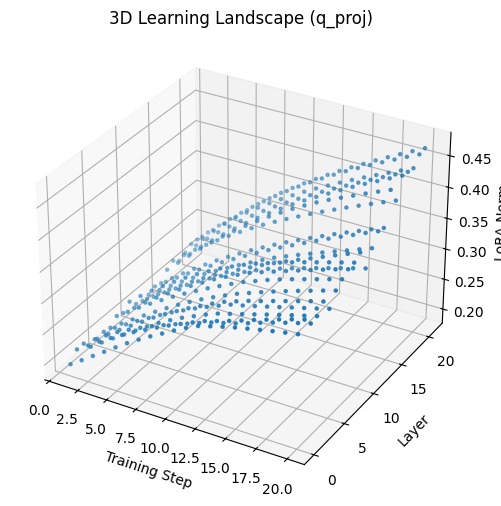

In [50]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="3d")

sample = points_df[points_df["proj"] == "q_proj"]

ax.scatter(
    sample["step"],
    sample["layer"],
    sample["norm"],
    s=5,
)

ax.set_xlabel("Training Step")
ax.set_ylabel("Layer")
ax.set_zlabel("LoRA Norm")
ax.set_title("3D Learning Landscape (q_proj)")

plt.show()


In [51]:
!pip install plotly


In [52]:
import plotly.express as px

fig = px.scatter_3d(
    points_df,
    x="step",
    y="layer",
    z="norm",
    color="proj",
    opacity=0.7,
    title="LoRA Learning Landscape (Interactive)",
)

fig.show()


In [53]:
points_dead = df_to_3d_points(df_dead)

points_dead["run"] = "degraded"
points_df["run"] = "healthy"

combined = pd.concat([points_df, points_dead])


In [54]:
fig = px.scatter_3d(
    combined,
    x="step",
    y="layer",
    z="norm",
    color="run",
    symbol="proj",
    opacity=0.6,
    title="Healthy vs Degraded Learning Landscapes",
)

fig.show()


 **Scaling **

In [55]:
from datasets import load_dataset

dataset = load_dataset("medmcqa", split="train[:50]")

train_samples = [medmcqa_to_instruction(dataset[i]) for i in range(50)]
len(train_samples)


50

In [56]:
def tokenize_fn(texts, max_length=128):
    return tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt",
    )

tokenized = tokenize_fn(
    [s["text"] for s in train_samples],
    max_length=128,
)

tokenized = {k: v.to(model.device) for k, v in tokenized.items()}

tokenized["input_ids"].shape


torch.Size([50, 128])

In [57]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-4)
pad_token_id = tokenizer.pad_token_id


In [58]:
from pathlib import Path
import json

LOG_PATH_LONG = Path("training_log_healthy_300.jsonl")
if LOG_PATH_LONG.exists():
    LOG_PATH_LONG.unlink()

def log_long_step(step, loss, lora_norms):
    with open(LOG_PATH_LONG, "a") as f:
        f.write(json.dumps({
            "step": step,
            "loss": loss,
            "lora_norms": lora_norms,
        }) + "\n")


In [59]:
model.train()

for step in range(1, 301):
    idx = (step - 1) % len(train_samples)

    input_ids = tokenized["input_ids"][idx:idx+1]
    attention_mask = tokenized["attention_mask"][idx:idx+1]

    labels = input_ids.clone()
    labels[labels == pad_token_id] = -100

    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        labels=labels,
    )

    loss = outputs.loss
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    raw_norms = get_lora_norms(model)
    clean_norms = simplify_lora_names(raw_norms)

    log_long_step(step, loss.item(), clean_norms)

    if step % 25 == 0:
        print(f"[HEALTHY] Step {step}/300 | Loss: {loss.item():.4f}")


[HEALTHY] Step 25/300 | Loss: 1.6412
[HEALTHY] Step 50/300 | Loss: 2.0147
[HEALTHY] Step 75/300 | Loss: 1.2083
[HEALTHY] Step 100/300 | Loss: 1.6466
[HEALTHY] Step 125/300 | Loss: 0.8957
[HEALTHY] Step 150/300 | Loss: 1.0869
[HEALTHY] Step 175/300 | Loss: 0.7144
[HEALTHY] Step 200/300 | Loss: 0.6659
[HEALTHY] Step 225/300 | Loss: 0.4880
[HEALTHY] Step 250/300 | Loss: 0.4801
[HEALTHY] Step 275/300 | Loss: 0.3713
[HEALTHY] Step 300/300 | Loss: 0.4170


In [60]:
import json
import pandas as pd

records_long = []
with open("training_log_healthy_300.jsonl") as f:
    for line in f:
        records_long.append(json.loads(line))

len(records_long)


300

In [61]:
rows = []
for r in records_long:
    row = {"step": r["step"]}
    row.update(r["lora_norms"])
    rows.append(row)

df_long = pd.DataFrame(rows).set_index("step")
df_long["total_lora_norm"] = df_long.sum(axis=1)

df_long.head()


,layer_0.q_proj,layer_0.k_proj,layer_0.v_proj,layer_0.o_proj,layer_1.q_proj,layer_1.k_proj,layer_1.v_proj,layer_1.o_proj,layer_2.q_proj,layer_2.k_proj,...,layer_19.o_proj,layer_20.q_proj,layer_20.k_proj,layer_20.v_proj,layer_20.o_proj,layer_21.q_proj,layer_21.k_proj,layer_21.v_proj,layer_21.o_proj,total_lora_norm
step,,,,,,,,,,,,,,,,,,,,,
1,0.037198,0.013225,0.013366,0.037889,0.037796,0.013251,0.013319,0.037791,0.037938,0.013314,...,0.037475,0.037366,0.013230,0.013285,0.037589,0.037306,0.013205,0.013288,0.037574,2.232963
2,0.058948,0.020990,0.022147,0.063650,0.063830,0.021686,0.021965,0.063306,0.064238,0.022044,...,0.060381,0.060100,0.021112,0.021371,0.061224,0.059777,0.020937,0.021630,0.061531,3.594212
3,0.077322,0.027697,0.029439,0.086792,0.086559,0.029511,0.029543,0.085546,0.087101,0.030347,...,0.080737,0.079738,0.028225,0.028515,0.082668,0.078626,0.027903,0.029131,0.082992,4.795470
4,0.094654,0.034261,0.035857,0.106957,0.106789,0.036468,0.035821,0.104806,0.106366,0.037752,...,0.099837,0.097950,0.034815,0.035292,0.103037,0.096266,0.034584,0.036345,0.103319,5.899195
5,0.108170,0.039656,0.041277,0.123157,0.123510,0.042232,0.041068,0.119971,0.122739,0.044337,...,0.118242,0.115419,0.041377,0.041805,0.122923,0.112735,0.040584,0.043168,0.123178,6.891659


In [62]:
df_early = df_long.loc[1:10]
df_early


,layer_0.q_proj,layer_0.k_proj,layer_0.v_proj,layer_0.o_proj,layer_1.q_proj,layer_1.k_proj,layer_1.v_proj,layer_1.o_proj,layer_2.q_proj,layer_2.k_proj,...,layer_19.o_proj,layer_20.q_proj,layer_20.k_proj,layer_20.v_proj,layer_20.o_proj,layer_21.q_proj,layer_21.k_proj,layer_21.v_proj,layer_21.o_proj,total_lora_norm
step,,,,,,,,,,,,,,,,,,,,,
1,0.037198,0.013225,0.013366,0.037889,0.037796,0.013251,0.013319,0.037791,0.037938,0.013314,...,0.037475,0.037366,0.013230,0.013285,0.037589,0.037306,0.013205,0.013288,0.037574,2.232963
2,0.058948,0.020990,0.022147,0.063650,0.063830,0.021686,0.021965,0.063306,0.064238,0.022044,...,0.060381,0.060100,0.021112,0.021371,0.061224,0.059777,0.020937,0.021630,0.061531,3.594212
3,0.077322,0.027697,0.029439,0.086792,0.086559,0.029511,0.029543,0.085546,0.087101,0.030347,...,0.080737,0.079738,0.028225,0.028515,0.082668,0.078626,0.027903,0.029131,0.082992,4.795470
4,0.094654,0.034261,0.035857,0.106957,0.106789,0.036468,0.035821,0.104806,0.106366,0.037752,...,0.099837,0.097950,0.034815,0.035292,0.103037,0.096266,0.034584,0.036345,0.103319,5.899195
5,0.108170,0.039656,0.041277,0.123157,0.123510,0.042232,0.041068,0.119971,0.122739,0.044337,...,0.118242,0.115419,0.041377,0.041805,0.122923,0.112735,0.040584,0.043168,0.123178,6.891659
6,0.120486,0.044440,0.045893,0.137532,0.138144,0.047194,0.045502,0.134060,0.138235,0.050314,...,0.136758,0.133009,0.047973,0.048266,0.142909,0.129243,0.046659,0.050025,0.142953,7.848080
7,0.132968,0.049393,0.050304,0.151152,0.151966,0.052004,0.049715,0.147627,0.152619,0.055888,...,0.155262,0.150655,0.054431,0.054636,0.162919,0.145766,0.052830,0.056917,0.162763,8.789202
8,0.144832,0.053967,0.054403,0.163910,0.164853,0.056673,0.053680,0.160768,0.166541,0.061265,...,0.174076,0.168420,0.060986,0.061084,0.183032,0.162305,0.059060,0.064033,0.183046,9.713569
9,0.155404,0.058139,0.058318,0.176581,0.176998,0.061095,0.057446,0.173990,0.179546,0.066482,...,0.192282,0.185314,0.067087,0.067401,0.202797,0.178058,0.064982,0.070851,0.202666,10.595961


In [63]:
classify_run(df_early)


'healthy'

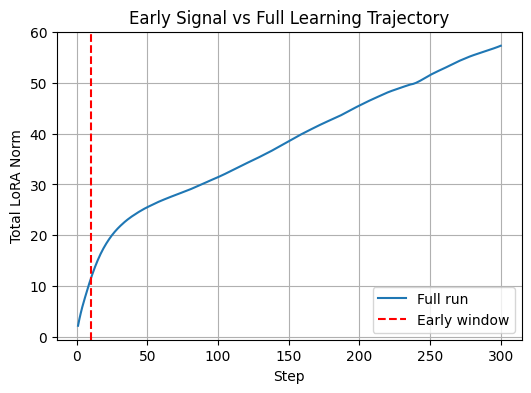

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(df_long.index, df_long["total_lora_norm"], label="Full run")
plt.axvline(10, linestyle="--", color="red", label="Early window")
plt.xlabel("Step")
plt.ylabel("Total LoRA Norm")
plt.legend()
plt.title("Early Signal vs Full Learning Trajectory")
plt.grid(True)
plt.show()
